In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [87]:
scrape_1 = pd.read_csv('../data/hot_scrape_20220526_184845.csv').drop('Unnamed: 0', axis = 1)
scrape_2 = pd.read_csv('../data/hot_scrape_20220527_153856.csv').drop('Unnamed: 0', axis = 1)
scrape_3 = pd.read_csv('../data/hot_scrape_20220528_112955.csv').drop('Unnamed: 0', axis = 1)
scrape_4 = pd.read_csv('../data/hot_scrape_20220529_173947.csv').drop('Unnamed: 0', axis = 1)
scrape_5 = pd.read_csv('../data/hot_scrape_20220530_104237.csv').drop('Unnamed: 0', axis = 1)

In [88]:
print(scrape_1.shape)
print(scrape_2.shape)
print(scrape_3.shape)
print(scrape_4.shape)
print(scrape_5.shape)

(7385, 24)
(7580, 24)
(7216, 24)
(7318, 24)
(8216, 24)


**Note**
The scrape was run manually five days in a row and received a different number of posts each time.

In [89]:
scrapes = scrape_1.iloc[:2000,:].append(scrape_2.iloc[:2000,:])\
                                .append(scrape_3.iloc[:2000,:])\
                                .append(scrape_4.iloc[:2000,:])\
                                .append(scrape_5.iloc[:2000,:]).reset_index(drop=True)

The daily scrapes are ordered from highest ranking position to lowest ranking position at the time of the scrape. For the purposes of our analysis, we will not require the entirety of the 37,715 posts. To keep the hottest posts (the top 100 to 500 per scrape), keep only the top 2,000 posts per day for a total dataset of 10,000 posts.

In [90]:
scrapes.shape

(10000, 24)

### Drop Helper Columns

In [91]:
scrapes.columns

Index(['title', 'subreddit', 'time_sampled', 'created_utc', 'num_comments',
       'author', 'author_premium', 'domain', 'edited', 'gilded', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_self', 'locked',
       'over_18', 'post_id', 'score', 'spoiler', 'subreddit_id',
       'subreddit_subscribers', 'upvote_ratio', 'post_age', 'post_age_min'],
      dtype='object')

In [92]:
# drop time columns used to create post_age_min column
scrapes.drop(['time_sampled', 'created_utc', 'post_age']
             , axis = 1, inplace = True)

### Remove duplicate titles

In [93]:
scrapes.drop_duplicates(subset = ['title'], inplace=True)
scrapes.reset_index(drop=True);

Want to make sure we are handling only submissions with unique titles to avoid a duplicative effect with things like:
  *  Cross-posting
  *  Reposting

### Handle Nulls

In [94]:
# identify columns that contain nulls along with their number of nulls
[(col, scrapes[col].isnull().sum()) for col in scrapes.columns if scrapes[col].isnull().sum()>0]

[('author', 3), ('author_premium', 3)]

In [95]:
# drop these nulls
scrapes = scrapes[(~scrapes.author.isnull()) & (~scrapes.author_premium.isnull())].reset_index(drop=True)

There were only 3 posts that did not have the `author` and `author_premium` fields filled out. Remove these.

### Create Target Column

In [96]:
target_val = scrapes.num_comments.median()
target = scrapes.num_comments.map(lambda x: x>target_val).astype(int)
target.rename('target')

scrapes['target'] = target

**Note** Our target will be the median value of `num_comments` across our dataset.

In [97]:
scrapes.num_comments.describe()

count     9553.000000
mean       137.941589
std        440.185049
min          0.000000
25%         17.000000
50%         41.000000
75%        109.000000
max      17303.000000
Name: num_comments, dtype: float64

A large range of comments from 0 to 17k. Expect to see a big right tail when graphed.

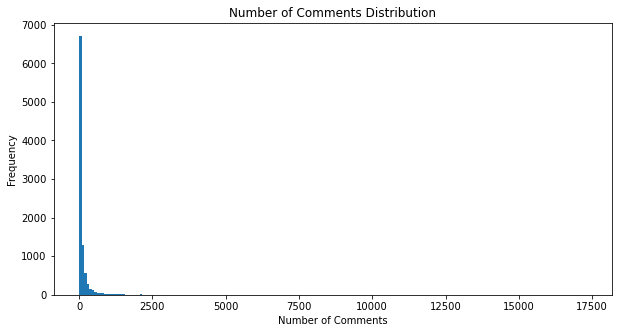

In [98]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(scrapes.num_comments, bins=200)

# fluff
ax.set_title('Number of Comments Distribution')
ax.set_xlabel('Number of Comments')
ax.set_ylabel('Frequency');

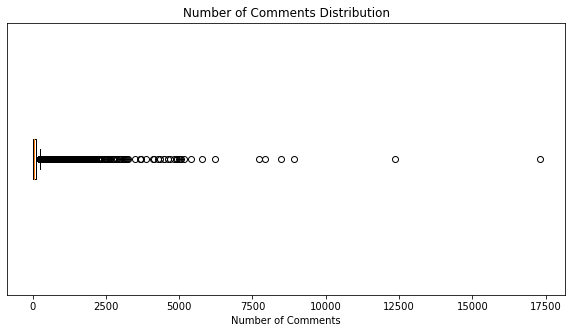

In [99]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# box plot
ax.boxplot(scrapes.num_comments, vert=False)

# fluff
ax.set_title('Number of Comments Distribution')
ax.set_xlabel('Number of Comments')
ax.tick_params(axis='y', left=False, labelleft=False)

**Observation** `num_comments` has a wide wide range of values including some posts 40 standard deviations from the mean! Since this is such a positively skewed distribution, outliers will be considered using a log scale when doing EDA.

In [100]:
# create logscale num_comments
scrapes['num_comments_logscale'] = np.log1p(scrapes.num_comments)

### Review Initial Correlations

In [101]:
scrapes.corr().iloc[-1:,:-1]

,num_comments,gilded,is_meta,is_original_content,is_reddit_media_domain,is_self,locked,over_18,score,spoiler,subreddit_subscribers,upvote_ratio,post_age_min,target
num_comments_logscale,0.540412,0.192297,NaN,0.003487,-0.207072,0.198608,0.030823,0.039964,0.485121,0.034852,0.333466,-0.476203,0.360115,0.790623


**Observations**
  *  `is_meta` is showing a value of NaN, this will need to be investigated
  *  There are a few variables that have a very low correlation (between -0.10 and 0.10). Consider dropping them.

#### Investigate `is_meta`

In [102]:
scrapes.is_meta.unique()

array([False])

In [103]:
# drop is_meta since it is all one value
scrapes.drop('is_meta', axis=1, inplace=True)

### Initial EDA

In [104]:
scrapes.dtypes

title                      object
subreddit                  object
num_comments                int64
author                     object
author_premium             object
domain                     object
edited                     object
gilded                      int64
is_original_content          bool
is_reddit_media_domain       bool
is_self                      bool
locked                       bool
over_18                      bool
post_id                    object
score                       int64
spoiler                      bool
subreddit_id               object
subreddit_subscribers       int64
upvote_ratio              float64
post_age_min              float64
target                      int32
num_comments_logscale     float64
dtype: object

**Observation**
  *  `author`, `author_premium` and `edited` are unexpectedly objects rather than bool or int
  *  `post_id` and `subreddit_id` may be alpha-numeric
  *  Everything else looks like the correct dtype

#### Review `title`

**Add word length, character length attributes**

In [105]:
def word_count(instr):
    '''takes in a str and trims all double spaces to return
       the number of words'''
    
    # remove all double spaces
    count = 0
    while '  ' in instr and count < 1_000_000 :
        instr = instr.replace('  ',' ')
        count += 1
    
    return len(instr.split(' '))

In [106]:
scrapes['title_length'] = scrapes['title'].map(lambda x: len(x))

In [107]:
scrapes['title_word_count'] = scrapes['title'].map(lambda x: word_count(x))

#### Review `title_length`

In [108]:
scrapes.title_length.describe()

count    9553.000000
mean       49.946718
std        45.573350
min         1.000000
25%        21.000000
50%        36.000000
75%        63.000000
max       300.000000
Name: title_length, dtype: float64

**Observation** There are no empty titles in our dataset. Additional cleaning will be completed during NLP.

In [109]:
scrapes.groupby('target').mean().title_length

target
0    41.960365
1    58.076468
Name: title_length, dtype: float64

**Observation** Posts considered hot by our target tended to have longer `title_length`s

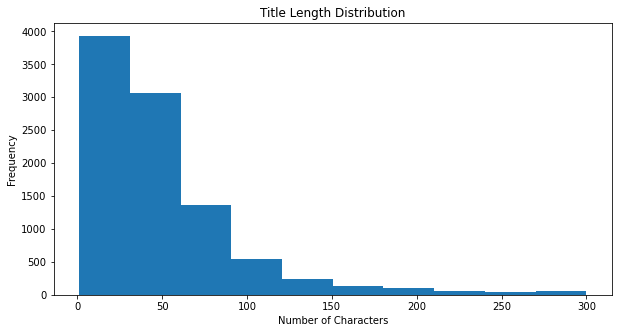

In [110]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(scrapes.title_length)

# fluff
ax.set_title('Title Length Distribution')
ax.set_xlabel('Number of Characters')
ax.set_ylabel('Frequency');

**Observation** Distribution of title length is right tailed with the highest density at 1-25 characters

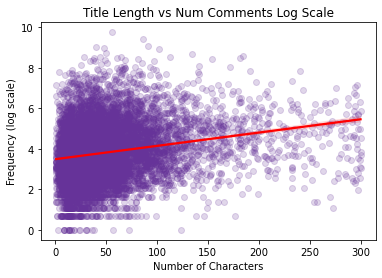

In [111]:
sns.regplot(x='title_length', y='num_comments_logscale', data = scrapes,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Title Length vs Num Comments Log Scale')
ax.set_xlabel('Number of Characters')
ax.set_ylabel('Frequency (log scale)');

**Observation** There are a few posts that are high up on the y scale but they aren't far enough from the rest of the data to remove.

#### Review `title_word_count`

In [112]:
scrapes.title_word_count.describe()

count    9553.000000
mean        8.969224
std         8.069364
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        61.000000
Name: title_word_count, dtype: float64

**Observation** Range of `title_word_count` from 1 to 61. Expect to see a positive skew based on the values of the third quartile and max.

In [113]:
scrapes.groupby('target').mean().title_word_count

target
0     7.598879
1    10.364174
Name: title_word_count, dtype: float64

**Observation** Posts considered hot by our target tended to have longer `title_word_count`s

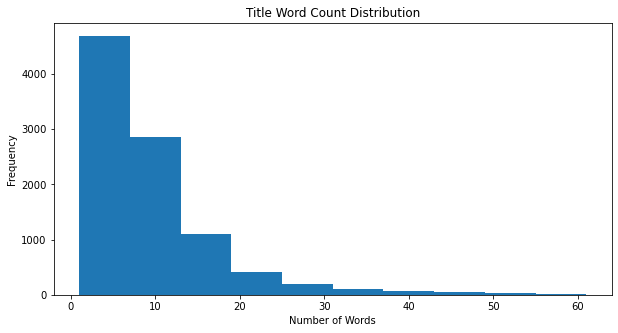

In [114]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(scrapes.title_word_count)

# fluff
ax.set_title('Title Word Count Distribution')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Frequency');

**Observation** Similar to `title_length`, the distribution is positively skewed with the first bin (in this case 1 to 5 words) being the most dense.

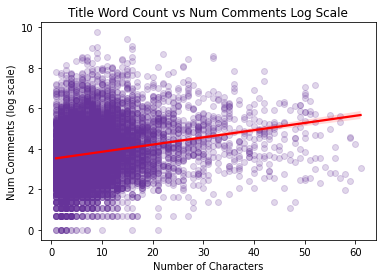

In [115]:
sns.regplot(x='title_word_count', y='num_comments_logscale', data = scrapes,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Title Word Count vs Num Comments Log Scale')
ax.set_xlabel('Number of Characters')
ax.set_ylabel('Num Comments (log scale)');

**Observation** No major outliers to remove.

#### Review `subreddit`

In [116]:
scrapes.groupby('subreddit').sum().target.describe()

count    2486.000000
mean        1.904264
std         3.049769
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        24.000000
Name: target, dtype: float64

There are too many subreddits to create dummy columns for; since a major attribute is the subreddit name, NLP could be performed on the subreddit name. However, that is out of the scope of this project and we can use `subreddit_subscribers` as a subreddit-based attribute to provide specific subreddit recommendations from our model (e.g. choose a subreddit with X amount of subscribers).

In [117]:
# drop subreddit
scrapes.drop('subreddit', axis=1, inplace=True)

#### Review `author`

In [118]:
len(scrapes.author.unique())

8477

In [119]:
# drop column ... that is almost 1 unique per row
scrapes.drop('author', axis = 1, inplace = True)

#### Review `author_premium`

In [120]:
scrapes.author_premium.unique()

array([True, False], dtype=object)

In [121]:
scrapes.author_premium.value_counts(normalize=True)

False    0.839422
True     0.160578
Name: author_premium, dtype: float64

In [122]:
# bool it and see the corr
scrapes['author_premium'] = scrapes.author_premium.astype(int)
scrapes.corr().loc['target','author_premium']

0.11281181972388561

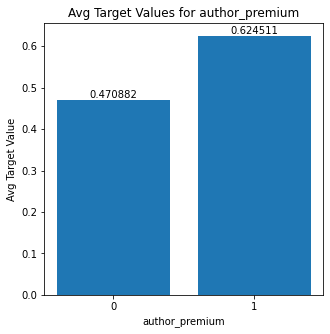

In [123]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

# bar graph for average target by value
ax.bar(scrapes.groupby('author_premium').mean().index,
       height = scrapes.groupby('author_premium').mean().target)

# fluff
ax.bar_label(ax.containers[0])
ax.set_xticks([0,1])
ax.set_title('Avg Target Values for author_premium')
ax.set_xlabel('author_premium')
ax.set_ylabel('Avg Target Value');

**Observation** Even though this is a pretty weak correlation, the distribution isn't lopsided too much (83% False) and there is a 15% gap between the average target rate for `author_premium` TRUE and FALSE. Keep this variable.

#### Review `domain`

In [124]:
len(scrapes.domain.unique())

489

**Observation** Similar to `subreddit` this just seems like too many values to dummy; create a metric that will identify successful domains.

In [129]:
scrapes.domain.describe()

count          9553
unique          489
top       i.redd.it
freq           5750
Name: domain, dtype: object

There are too many domains to create dummy columns for. Look at the top value counts.

In [128]:
scrapes.domain.value_counts(normalize=True)[:5]

i.redd.it      0.601905
v.redd.it      0.173453
i.imgur.com    0.065006
reddit.com     0.045849
gfycat.com     0.006281
Name: domain, dtype: float64

77% of domain values are going to be `is_reddit_media_domain` TRUE. The third most popular domain is only 6.5% of values. For this reason, drop `domain` and utilize `is_reddit_media_domain`.

In [130]:
# drop
scrapes.drop('domain', axis = 1, inplace = True)

#### Review `edited`

In [131]:
scrapes.edited.unique()[:10]

array(['False', '1653605084.0', '1653586491.0', '1653605587.0',
       '1653598322.0', '1653585974.0', '1653581994.0', '1653598639.0',
       '1653587977.0', '1653600605.0'], dtype=object)

As noted previously, this was expected to be bool and it appears that the TRUE values are the timestamps of the edits.

In [132]:
# convert to bool
is_edited = scrapes.edited.map(lambda x: x != 'False').astype(int)

scrapes['edited'] = is_edited
scrapes.rename(columns = {'edited': 'is_edited'}, inplace=True)

In [133]:
scrapes.is_edited.value_counts(normalize=True)

0    0.988067
1    0.011933
Name: is_edited, dtype: float64

In [134]:
# too many zeros. Drop this column
scrapes.drop('is_edited', axis = 1, inplace = True)

#### Review `gilded`

In [135]:
scrapes.gilded.value_counts(normalize=True)

0    0.967445
1    0.027740
2    0.003664
4    0.000523
3    0.000523
5    0.000105
Name: gilded, dtype: float64

In [136]:
# zero has too high of concentration, drop it.
scrapes.drop('gilded', axis = 1, inplace = True)

#### Review `is_original_content`

In [137]:
scrapes.is_original_content.value_counts(normalize=True)

False    0.978541
True     0.021459
Name: is_original_content, dtype: float64

In [138]:
# too many zeros. Drop this column
scrapes.drop('is_original_content', axis = 1, inplace = True)

#### Review `is_reddit_media_domain`

In [139]:
scrapes.is_reddit_media_domain.value_counts(normalize=True)

True     0.775359
False    0.224641
Name: is_reddit_media_domain, dtype: float64

77% of domain values are reddit media domains; right in line with what was expected from the `domain` value distribution.

In [140]:
# convert to ints
scrapes.is_reddit_media_domain = scrapes.is_reddit_media_domain.astype(int)

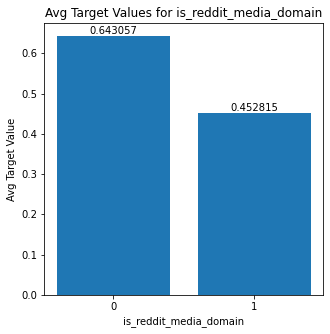

In [141]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

# bar graph for average target by value
ax.bar(scrapes.groupby('is_reddit_media_domain').mean().index,
       height = scrapes.groupby('is_reddit_media_domain').mean().target)

# fluff
ax.bar_label(ax.containers[0])
ax.set_xticks([0,1])
ax.set_title('Avg Target Values for is_reddit_media_domain')
ax.set_xlabel('is_reddit_media_domain')
ax.set_ylabel('Avg Target Value');

**Observation** Keep this variable. There is an almost 20% difference in average `target` rate.

#### Review `is_self`

In [142]:
scrapes.is_self.value_counts(normalize=True)

False    0.950801
True     0.049199
Name: is_self, dtype: float64

In [143]:
# too many values in False. Drop this column
scrapes.drop('is_self', axis = 1, inplace = True)

#### Review `locked`

In [144]:
scrapes.locked.value_counts(normalize=True)

False    0.994975
True     0.005025
Name: locked, dtype: float64

In [145]:
# too many values in False. Drop this column
scrapes.drop('locked', axis = 1, inplace = True)

#### Review `over_18`

In [146]:
scrapes.over_18.value_counts(normalize=True)

False    0.98053
True     0.01947
Name: over_18, dtype: float64

In [147]:
# too many values in False. Drop this column
scrapes.drop('over_18', axis = 1, inplace = True)

#### Review `post_id`

In [148]:
len(scrapes.post_id.unique())

9553

In [149]:
# drop
scrapes.drop('post_id', axis=1, inplace=True)

**Note** This was dropped because it is the unique identifier of a post. Since this isn't controlled by the user, it is out of scope of this investigation.

#### Review `score`

In [150]:
# drop
scrapes.drop('score', axis=1, inplace=True)

**Note** `score` is similar to `num_comments` in that it is a measure of engagement on our post. Since we are trying to understand what drives engagement, keeping this variable does not make sense.

#### Review `spoiler`

In [151]:
scrapes.spoiler.value_counts(normalize=True)

False    0.98702
True     0.01298
Name: spoiler, dtype: float64

In [152]:
# too many values in False. Drop this column
scrapes.drop('spoiler', axis = 1, inplace = True)

#### Review `subreddit_id`

In [153]:
# drop
scrapes.drop('subreddit_id', axis=1, inplace=True)

**Note** This is the unique ID for a `subreddit`. That information is already captured in the `is_successful_subreddit` column.

#### Review `subreddit_subscribers`

In [154]:
scrapes.subreddit_subscribers.describe()

count    9.553000e+03
mean     2.071062e+06
std      5.213268e+06
min      5.381000e+03
25%      1.570570e+05
50%      4.325310e+05
75%      1.350113e+06
max      4.085491e+07
Name: subreddit_subscribers, dtype: float64

A range from 5,381 to 40,854,910, expect this to be very right skewed.

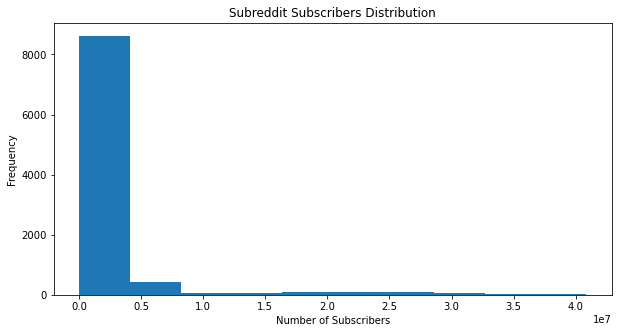

In [156]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(scrapes.subreddit_subscribers)

# fluff
ax.set_title('Subreddit Subscribers Distribution')
ax.set_xlabel('Number of Subscribers')
ax.set_ylabel('Frequency');

**Observation** Because of the characteristics of Reddit, there are wide variety of subreddits and a wide variety of popularity/subscriber counts within. I suspect that the higher the amount of subscribers, the better the chance a high `num_comments`. To account for this when looking for outliers, log scale `subreddit_subscribers`.

In [157]:
# log scale subreddit subscribers to find outliers
scrapes['subreddit_subscribers_logscale'] =\
    np.log1p(scrapes.subreddit_subscribers)

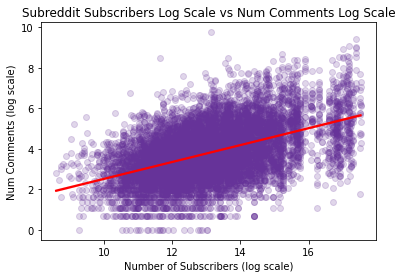

In [158]:
sns.regplot(x='subreddit_subscribers_logscale', y='num_comments_logscale', data = scrapes,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Subreddit Subscribers Log Scale vs Num Comments Log Scale')
ax.set_xlabel('Number of Subscribers (log scale)')
ax.set_ylabel('Num Comments (log scale)');

**Observation** There are two values above the main population of the distribution between 8 and 10 on the y-axis, 11 and 14 on the x-axis, that look like outliers. Identify and remove them.

In [159]:
#locate outlier by general area
scrapes[scrapes.num_comments_logscale>8][scrapes.subreddit_subscribers_logscale>11]\
    [scrapes.subreddit_subscribers_logscale<14].iloc[:,-5:]

C:\Users\Larry\AppData\Local\Temp/ipykernel_17324/395135513.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scrapes[scrapes.num_comments_logscale>8][scrapes.subreddit_subscribers_logscale>11]\


,target,num_comments_logscale,title_length,title_word_count,subreddit_subscribers_logscale
265,1,8.497603,38,6,11.630966
1647,1,8.264106,51,8,13.555582
6340,1,8.033334,93,21,13.896418
7108,1,9.758693,56,9,13.123023
8394,1,8.499640,182,32,13.633053


Appears that post number 7108 and post number 265 are the outliers.

In [160]:
# remove posts 7108 and 265
scrapes.drop([7108,265], inplace=True)

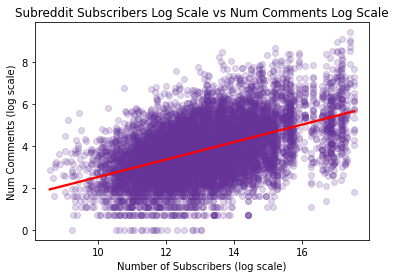

In [161]:
sns.regplot(x='subreddit_subscribers_logscale', y='num_comments_logscale', data = scrapes,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Subreddit Subscribers Log Scale vs Num Comments Log Scale')
ax.set_xlabel('Number of Subscribers (log scale)')
ax.set_ylabel('Num Comments (log scale)');

**Observation** No more outliers to be removed.

#### Review `upvote_ratio`


In [162]:
# drop
scrapes.drop('upvote_ratio', axis=1, inplace=True)

**Note** `upvote_ratio` is similar to `num_comments` in that it is a measure of engagement on our post. Since we are trying to understand what drives engagement, keeping this variable does not make sense.

#### Review `post_age_min`

In [78]:
scrapes.post_age_min.describe()

count    9551.000000
mean      468.899599
std       226.761758
min        22.599620
25%       295.384241
50%       439.455453
75%       608.202900
max      1426.258418
Name: post_age_min, dtype: float64

A range from 22 minutes to 1,426 minutes (almost 24 hours). This doesn't appear to be as skewed as the previous qualitative variables like `subreddit_subscribers`.

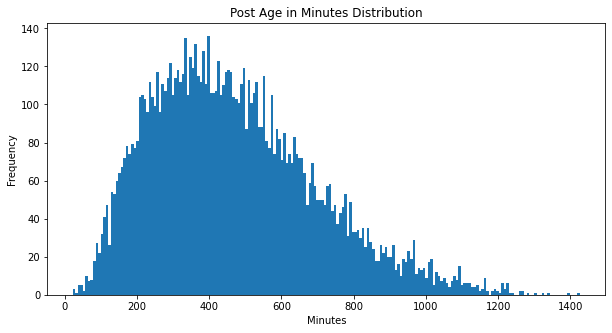

In [79]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(scrapes.post_age_min, bins=200)

# fluff
ax.set_title('Post Age in Minutes Distribution')
ax.set_xlabel('Minutes')
ax.set_ylabel('Frequency');

**Observation** Pretty close to a normal distribution with a right tail. No obvious outliers next, look more closely next.

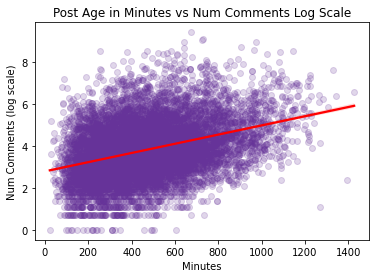

In [163]:
sns.regplot(x='post_age_min', y='num_comments_logscale', data = scrapes,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Post Age in Minutes vs Num Comments Log Scale')
ax.set_xlabel('Minutes')
ax.set_ylabel('Num Comments (log scale)');

**Observation** The distribution seems to be slightly positively skewed and the there don't appear to be any outliers. No cleaning of this variable needed.

### Final dataframe pre-NPL

In [164]:
scrapes.columns

Index(['title', 'num_comments', 'author_premium', 'is_reddit_media_domain',
       'subreddit_subscribers', 'post_age_min', 'target',
       'num_comments_logscale', 'title_length', 'title_word_count',
       'subreddit_subscribers_logscale'],
      dtype='object')

`subreddit_subscribers_logscale` was used to find outliers for `subreddit_subscribers`. Drop it.

In [165]:
scrapes.drop('subreddit_subscribers_logscale', axis=1, inplace=True)

In [166]:
# move target, num_comments, num_comments_logscale to first columns of df
temp_col = scrapes.loc[:,['num_comments','num_comments_logscale','target']]
scrapes = scrapes.drop(['num_comments','num_comments_logscale','target']
                       , axis = 1)
scrapes = temp_col.join(scrapes)

del temp_col

In [167]:
scrapes.dtypes

num_comments                int64
num_comments_logscale     float64
target                      int32
title                      object
author_premium              int32
is_reddit_media_domain      int32
subreddit_subscribers       int64
post_age_min              float64
title_length                int64
title_word_count            int64
dtype: object

Dtypes look correct

In [168]:
scrapes.to_csv('../data/pre_nlp_data.csv', index = False)

### Final Thoughts

Given the distributions observed during EDA such as `subreddit_subscribers`, `title_length`, `title_word_count`, among the other kept columns; the question about finding hot posts from underlying, scraped data should be able to be answered.

Moreso, NPL should provide even more insight into the data and increase our chances of a successful model.